# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
# Import everything needed
import pickle
import random
from scipy import ndimage
from sklearn.model_selection import train_test_split
from IPython.display import Image
from IPython.display import display
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline



---
## Step 0: Load The Data

In [2]:
# Open training and testing data and make a random validation set
# 20% of the training data

training_file = "/media/frank/Zusatz/CarND-Traffic-Sign-Classifier-Project-master/train.p"
testing_file = "/media/frank/Zusatz/CarND-Traffic-Sign-Classifier-Project-master/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
 
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

pick_random = random.randint(0,9999)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=pick_random)

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
# Number of testing, training and validation examples
n_train = len(X_train)
n_validation = len(X_validation)
n_test = len(X_test)

# Shape of a traffic sign image
image_shape = X_train[0].shape

# All classes in the training dataset
n_classes = np.unique(np.asarray(train['labels'])).size

sign_number = 16

print("Image Shape: {}".format(image_shape))
print()
print("Training Set:   {} samples".format(n_train))
print("Validation Set: {} samples".format(n_validation))
print("Test Set:       {} samples".format(n_test))
print("Classes in whole Set (Training and Validation): {} samples".format(n_classes))
print("Count of specific sign ("+str(sign_number)+") in whole Set: {} samples".format(np.count_nonzero(train['labels']==sign_number)))
print("Percentage of this sign in whole Set: {}%".format(np.count_nonzero(train['labels']==sign_number)*100/(n_train+n_validation)))

Image Shape: (32, 32, 3)

Training Set:   31367 samples
Validation Set: 7842 samples
Test Set:       12630 samples
Classes in whole Set (Training and Validation): 43 samples
Count of specific sign (16) in whole Set: 420 samples
Percentage of this sign in whole Set: 1.071182636639547%


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

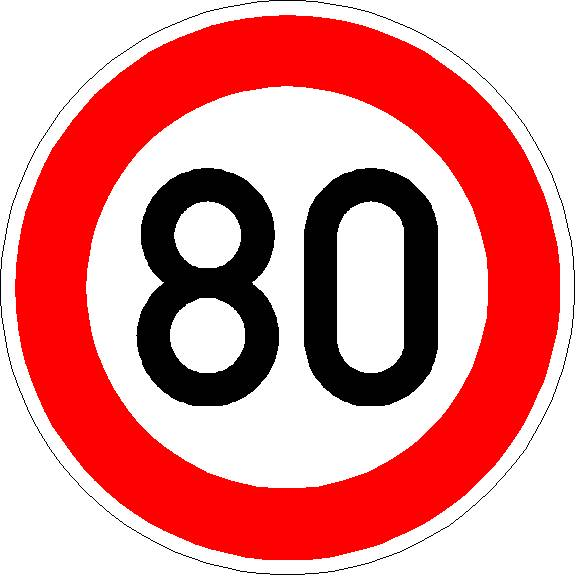

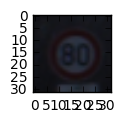

In [4]:
# Choose a random item in the training set and plot it
# ...and the associated sign from the signnames-list
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
Image(filename='Pictures/'+str(y_train[index])+'.jpg', width=100)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
# Shuffle training dataset and choose epochs and batch size
X_train, y_train = shuffle(X_train, y_train)

EPOCHS = 15
BATCH_SIZE = 256

In [6]:
# Implementation of the neural network
# Started with LeNet and changed through testing different approaches.
def SignNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    c1_weights = tf.Variable(tf.truncated_normal(shape=(5,5,3,6), mean = mu, stddev = sigma))
    c1_bias = tf.Variable(tf.zeros(6))
    c1 = tf.nn.conv2d(x, c1_weights, strides=[1,1,1,1], padding = 'VALID')

    # Activation with elu.
    c1 = tf.nn.elu(c1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    c1 = tf.nn.avg_pool(c1,ksize = [1,2,2,1],strides = [1,2,2,1], padding = 'VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    c2_weights = tf.Variable(tf.truncated_normal(shape=(5,5,6,16), mean = mu, stddev = sigma))
    c2_bias = tf.Variable(tf.zeros(16))
    c2 = tf.nn.conv2d(c1, c2_weights, strides=[1,1,1,1], padding = 'VALID')
                                               
    # Activation with elu.
    c2 = tf.nn.elu(c2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    c2 = tf.nn.avg_pool(c2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    c_flat = tf.contrib.layers.flatten(c2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    c3_weights = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    c3_bias = tf.Variable(tf.zeros(120))
    c3 = tf.add(tf.matmul(c_flat, c3_weights), c3_bias)
    
    # Activation with elu.
    c3 = tf.nn.elu(c3)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    c4_weights = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    c4_bias = tf.Variable(tf.zeros(84))
    c4 = tf.add(tf.matmul(c3, c4_weights), c4_bias)
    c4 = tf.nn.dropout(c4, keep_prob = keep_prob)
    
    # Activation with elu.
    c4 = tf.nn.elu(c4)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    c5_weights = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    c5_bias = tf.Variable(tf.zeros(43))
    logits = tf.add(tf.matmul(c4, c5_weights), c5_bias)
    
    return logits

In [7]:
# Choosing learning rate and optimizer to train the network
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

rate = 0.001

logits = SignNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.RMSPropOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Training...

EPOCH 1 ...
Validation Accuracy = 0.432

EPOCH 2 ...
Validation Accuracy = 0.762

EPOCH 3 ...
Validation Accuracy = 0.805

EPOCH 4 ...
Validation Accuracy = 0.895

EPOCH 5 ...
Validation Accuracy = 0.943

EPOCH 6 ...
Validation Accuracy = 0.953

EPOCH 7 ...
Validation Accuracy = 0.948

EPOCH 8 ...
Validation Accuracy = 0.961

EPOCH 9 ...
Validation Accuracy = 0.966

EPOCH 10 ...
Validation Accuracy = 0.964

EPOCH 11 ...
Validation Accuracy = 0.978

EPOCH 12 ...
Validation Accuracy = 0.967

EPOCH 13 ...
Validation Accuracy = 0.978

EPOCH 14 ...
Validation Accuracy = 0.977

EPOCH 15 ...
Validation Accuracy = 0.978

Model saved


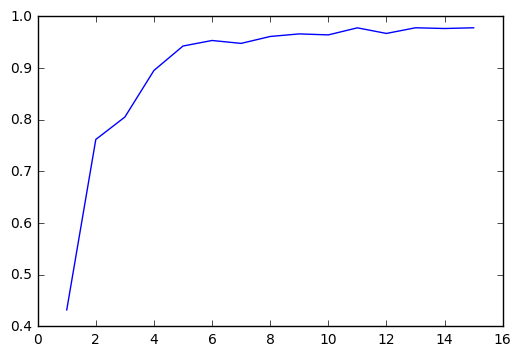

In [8]:
helplist = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        helplist.append(validation_accuracy)
    x_plot = np.asarray([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
    y_plot = np.asarray(helplist)
    plt.plot(x_plot, y_plot)
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'signnet')
    print("Model saved")

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [9]:
### I split the shuffled training set into
### two parts. The training set (80% of data) and the validation set (20% of data).
### I tested a bit with other percentages, but think that this choice is sufficient.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [10]:
### Not much to write about. Just shuffled the training set again for the sake of it.
### Choosing Epochs = 15 and batchsize = 256. In general 10 Epochs are enough, when testing
### the network in my eyes - but 15 seems to be a safer bet.


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [11]:
### First Layer: Convolutional with input 32x32x3 (imagessize from the database) and output 28x28x6
### Activation Function: Elu with 'exp(features)-1' for '< 0' and 'features' for '>= 0'
### Avg. Pooling: input 28x28x6 and output 14x14x6
### Second Layer: Convolutional with input 14x14x6 and output 10x10x16
### Activation Function: Elu
### Avg. Pooling: input 10x10x16 and output 5x5x16
### Flatten: input 5x5x16 to output 400
### Third Layer: Fully Connected with input 400 and output 120
### Activation Function: Elu
### Fourth Layer: Fully Connected with input 120 and output 84
### Dropout with keep_prob = 0.5
### Activation Function: Elu
### Fifth Layer: Fully Connected with input 84 and output 43
###_________________________________________________________________________________________
### The basic structure of LeNet seems to work well, but I applicated some changes.
### For the Activation Function Elu is giving me slightly better results than the Relus.
### Furthermore I'm using Average Pooling and not Max Pooling.
### Between the fourth and fifth Layer I am using dropout to reduce the chance of overfitting.


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

In [12]:
### The learning rate is choosen with rate = 0.001 which works fine with the RMSPropOptimizer.
### AdamOptimizer works nearly as good, but seems to be a bit more instable (not much, it was a close call)
### With a learning rate equal to 0.01 Adagrad and Ftrl give good results, but not nearly as great
### as RMSProp or Adam. I get all needed information for it from https://www.tensorflow.org/api_docs/python/nn/
### For the batch size and epochs see Question 2. 
### The numbers for mu and sigma were adopted for LeNet.

### P.S: Want to try regulization, if find some more time to work on this project.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

In [13]:
### I followed the recommanded way of using the LeNet network for the last lesson as
### a starting point. From that point on it was just trial and error. Searching through different 
### approaches @tensorflow.org
### First I changes MaxPooling to AvgPooling which gave me slightly better results.
### Using the dropout seems not to change the results much, but it is good to know to do something
### against overfitting.
### Testing some more and came to use RMSProp and Elu Activations
### Tried to change the hyperparameters throughout the testing and closed with the ones chosen.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

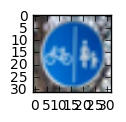

In [14]:
# Print one of the test images from the directory 'Test'
number = 8
test_image = ndimage.imread('Test/'+str(number)+'.png')
plt.figure(figsize=(1,1))
plt.imshow(test_image)
plt.show()
print()

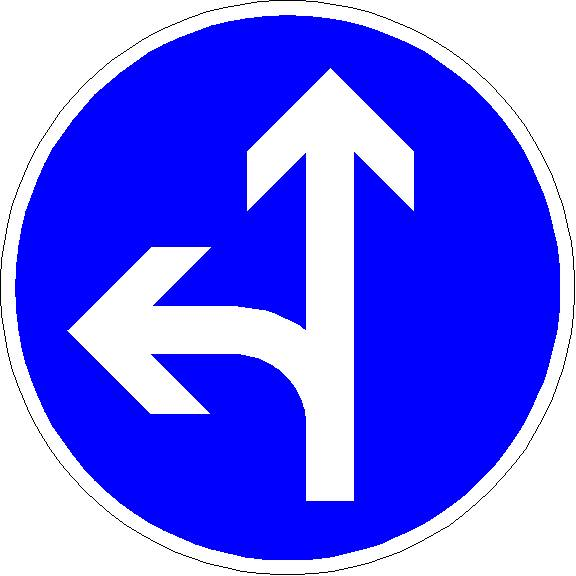

In [15]:
# Shows the class SignNet(x) chooses for 'test_image'
# The signs in the directory 'Pictures' are from www.bast.de/DE/Verkehrstechnik/Fachthemen/v1-verkehrszeichen/vz-start-2013.htm
test_neu = tf.argmax(logits, 1)

with tf.Session() as sess:
    loader = tf.train.import_meta_graph('signnet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    
    sess = tf.get_default_session()
    
    testindex = sess.run(test_neu, feed_dict={x: np.asarray([test_image]), keep_prob: 1.0})
Image(filename='Pictures/'+str(testindex[0])+'.jpg', width=100)

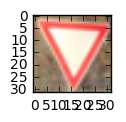

Softmaxprobability: 1.0


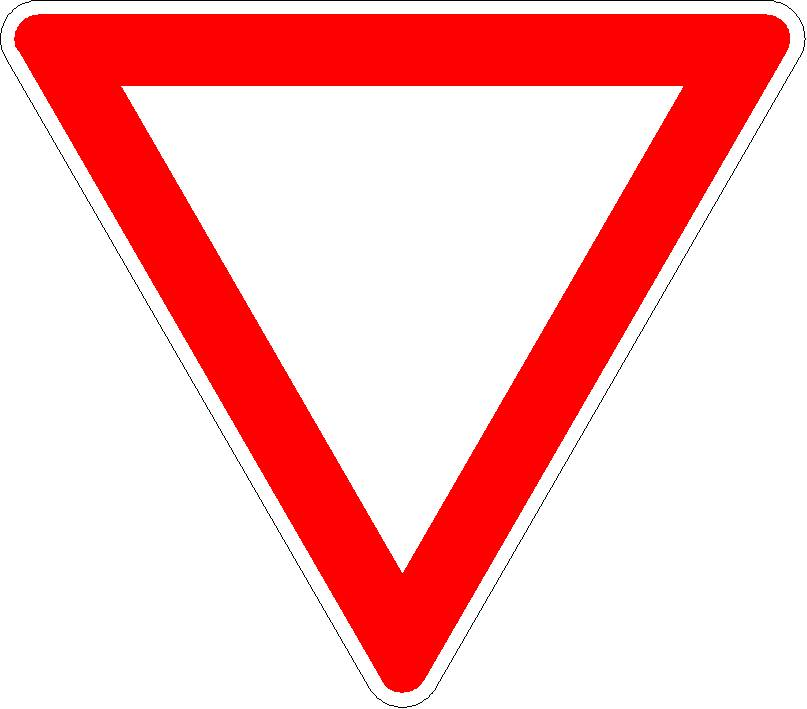

Softmaxprobability: 3.21245e-15


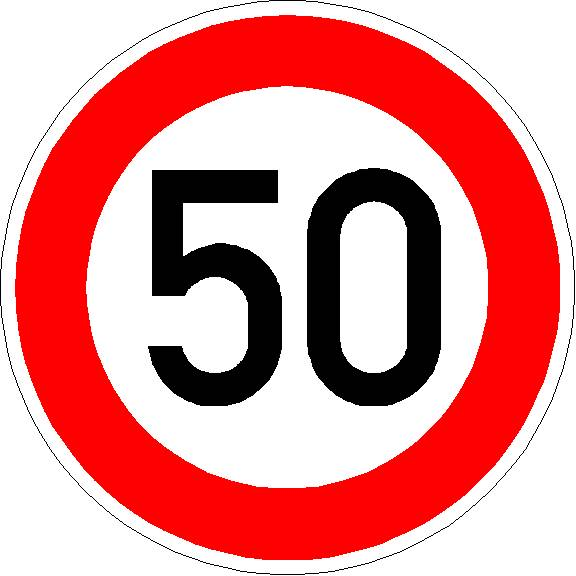

Softmaxprobability: 7.24074e-19


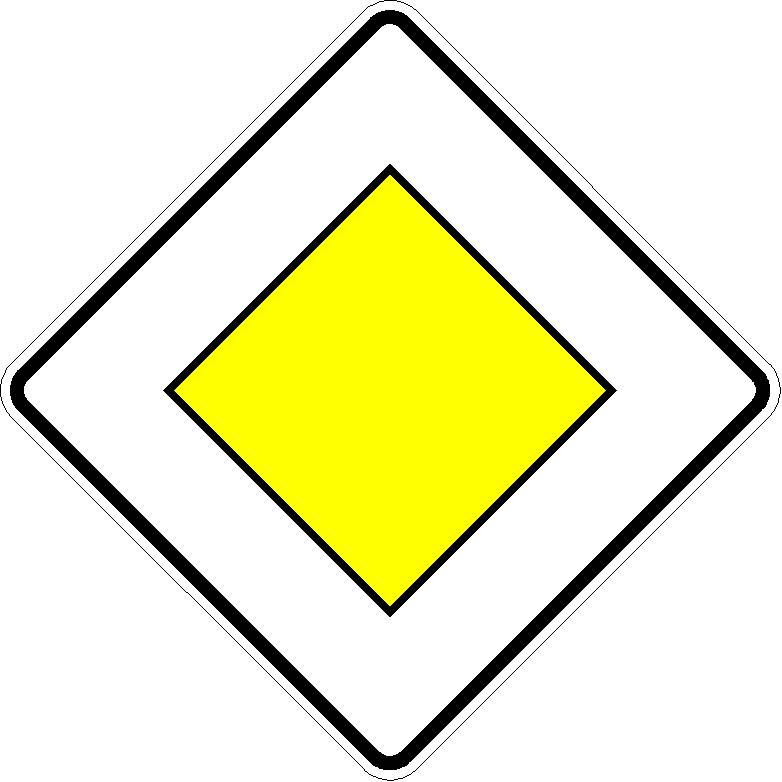

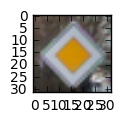

Softmaxprobability: 1.0


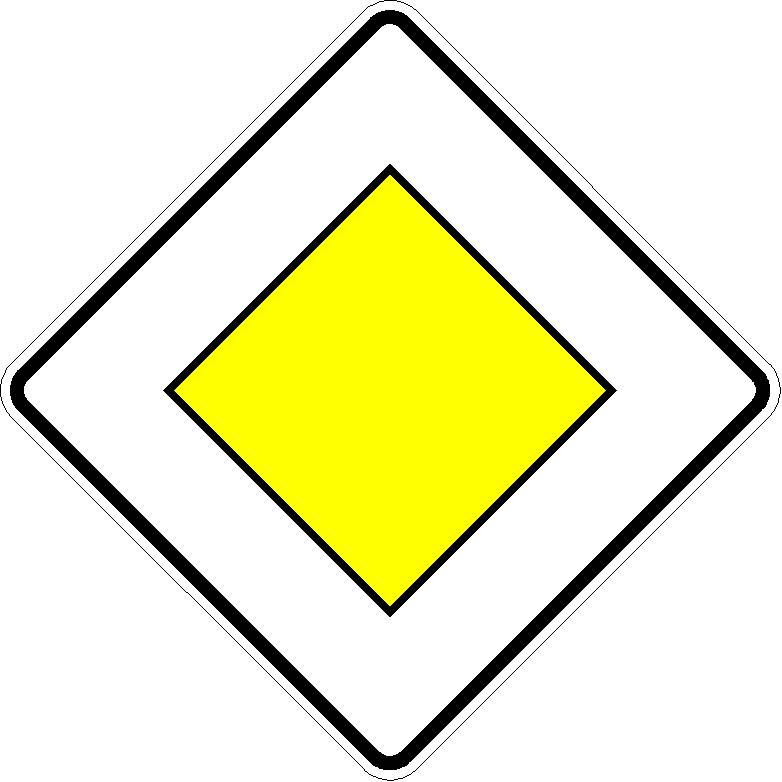

Softmaxprobability: 4.90092e-26


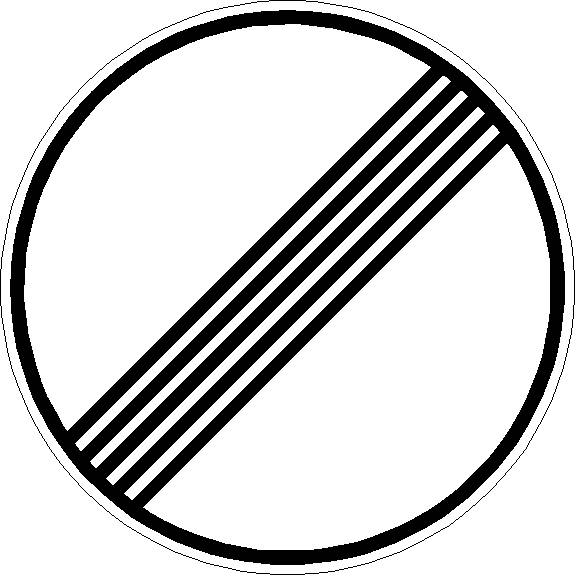

Softmaxprobability: 3.76935e-26


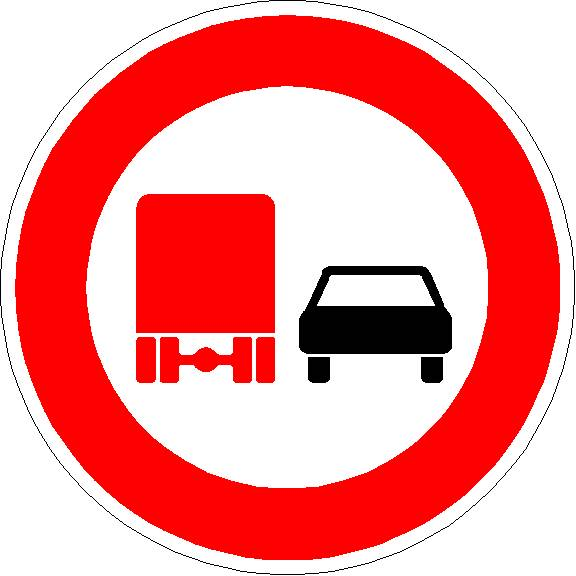

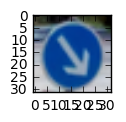

Softmaxprobability: 1.0


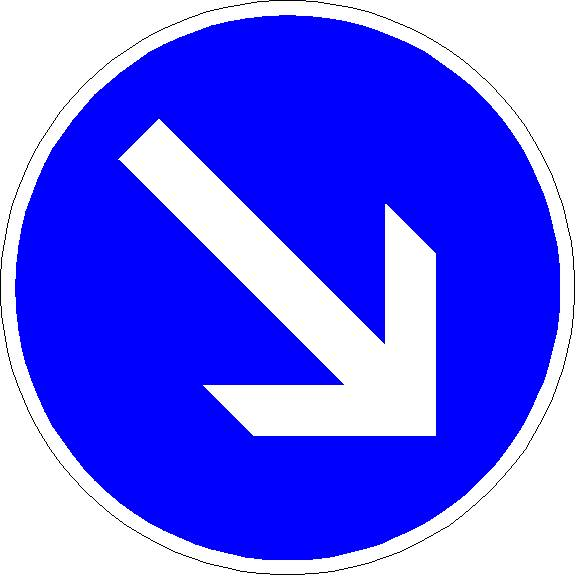

Softmaxprobability: 8.46489e-20


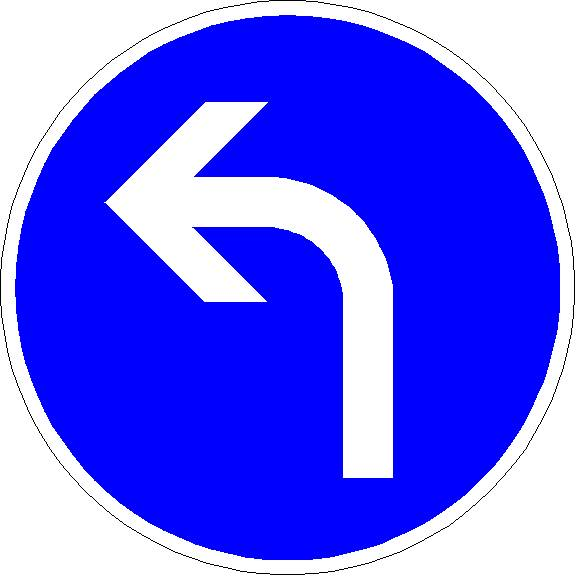

Softmaxprobability: 1.3284e-30


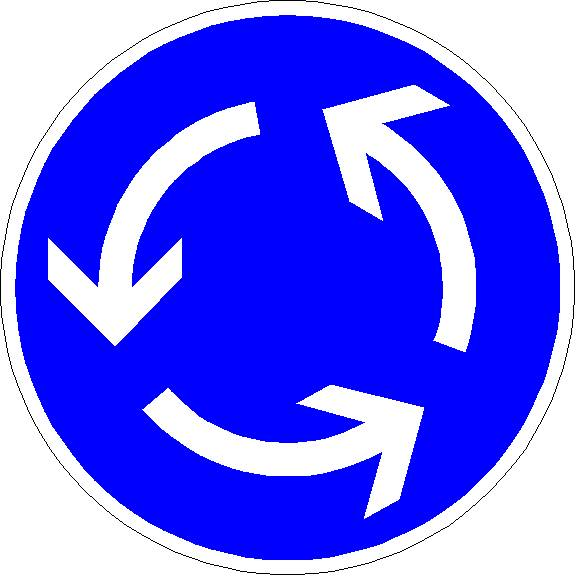

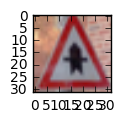

Softmaxprobability: 0.999998


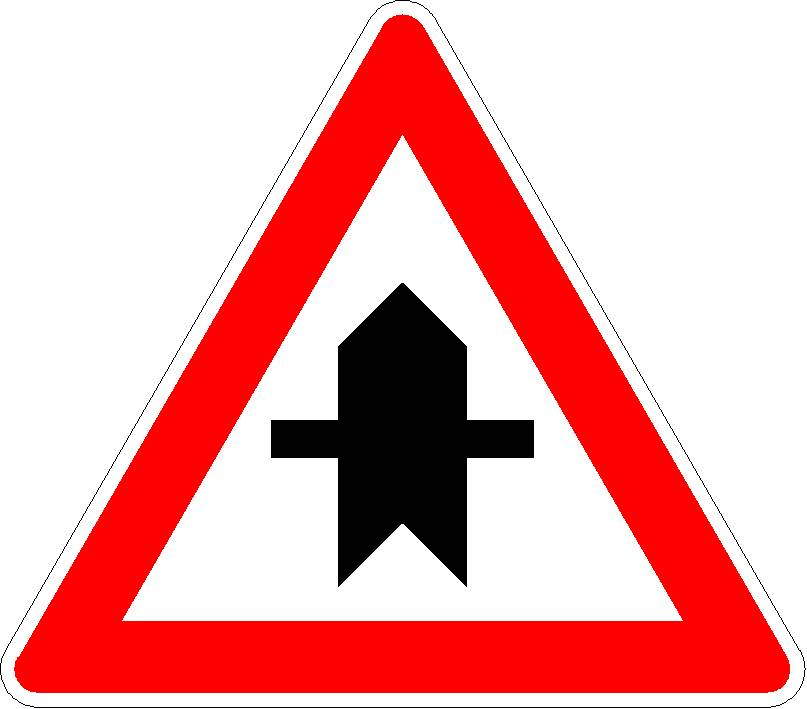

Softmaxprobability: 1.93402e-06


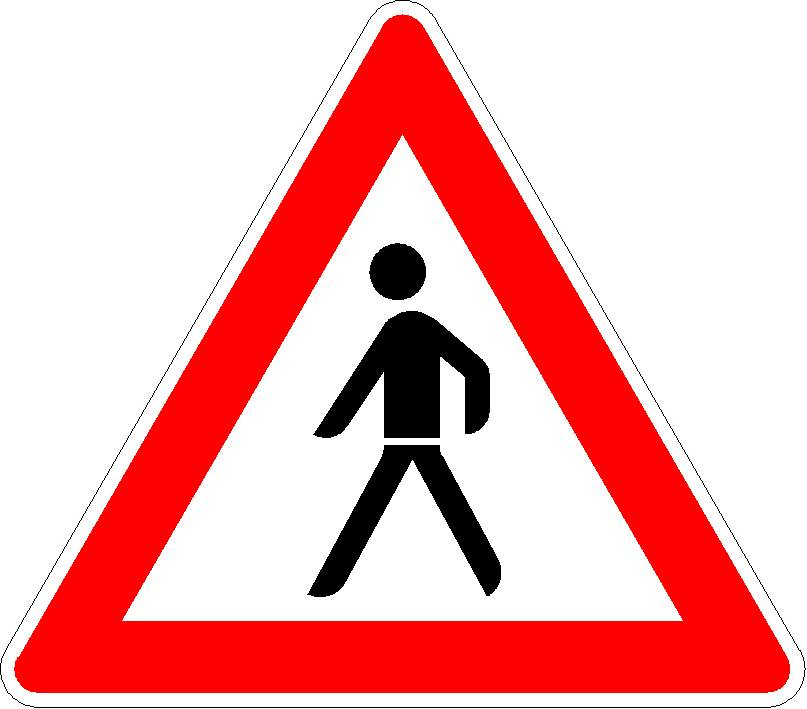

Softmaxprobability: 1.16051e-07


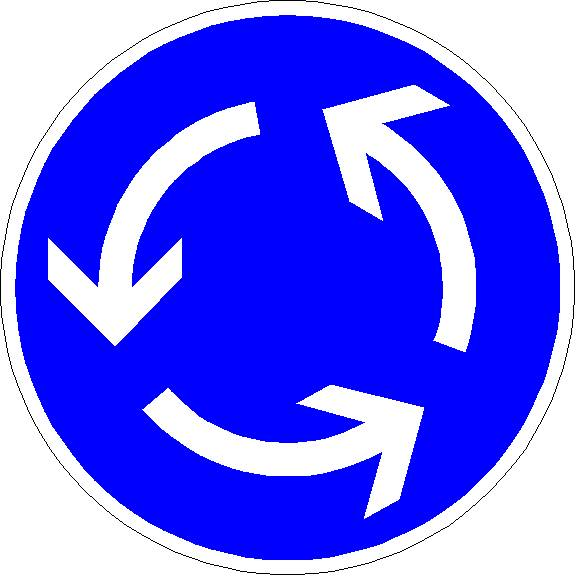

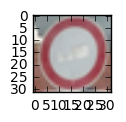

Softmaxprobability: 0.992266


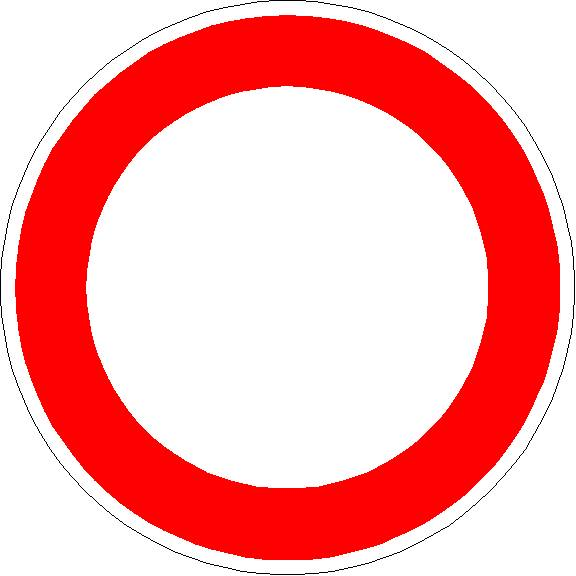

Softmaxprobability: 0.00267034


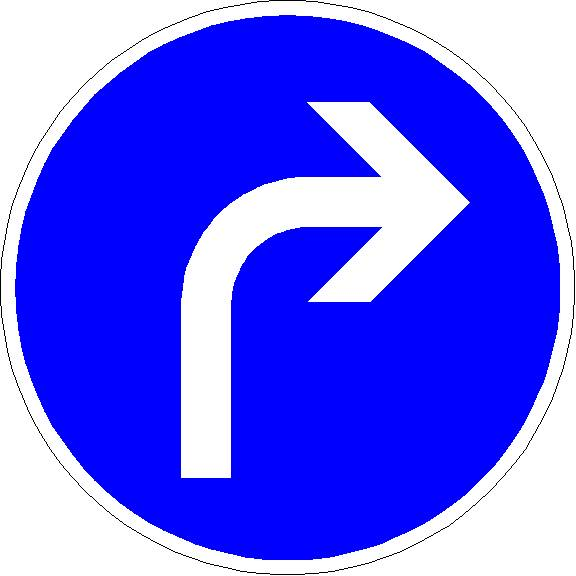

Softmaxprobability: 0.00198965


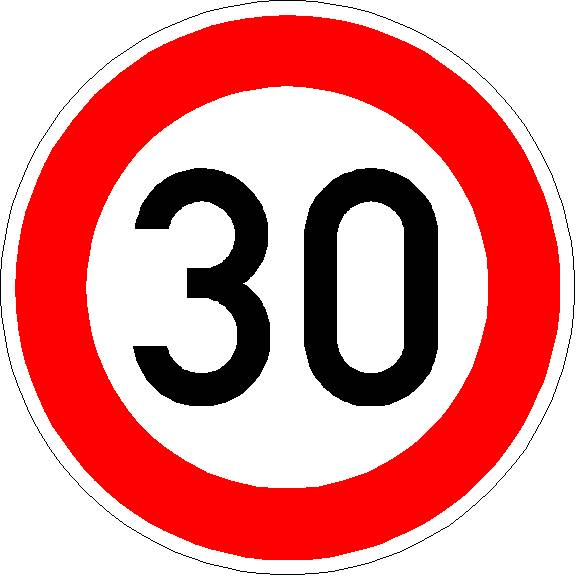

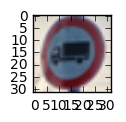

Softmaxprobability: 0.991706


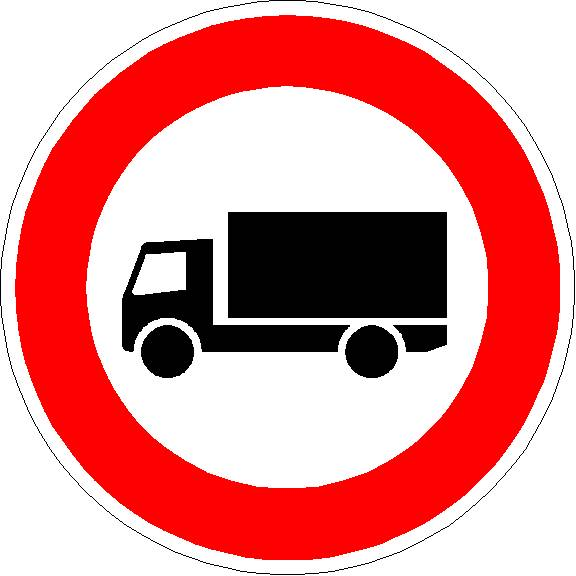

Softmaxprobability: 0.00805054


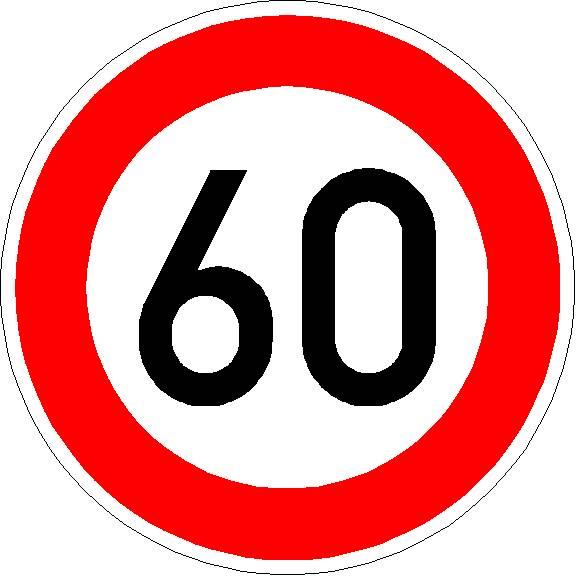

Softmaxprobability: 0.000138795


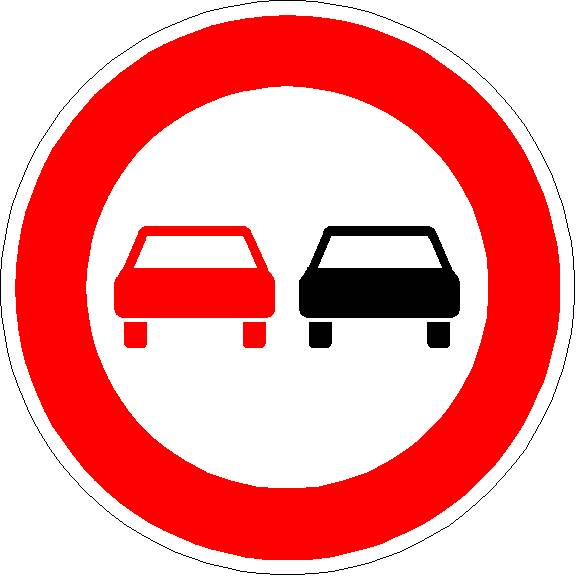

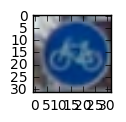

Softmaxprobability: 0.860595


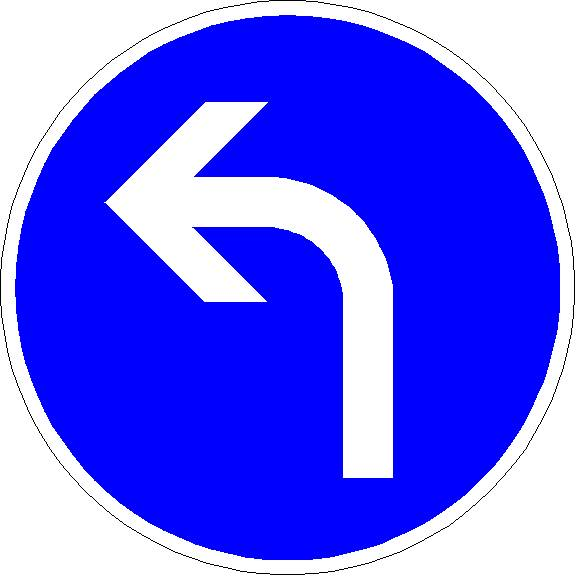

Softmaxprobability: 0.138495


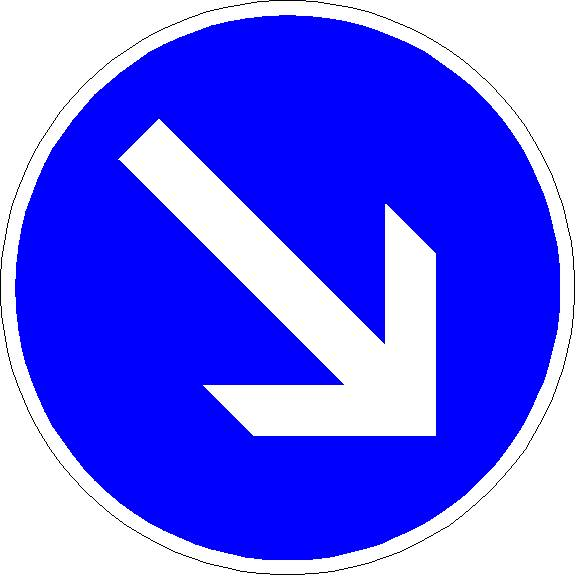

Softmaxprobability: 0.000910054


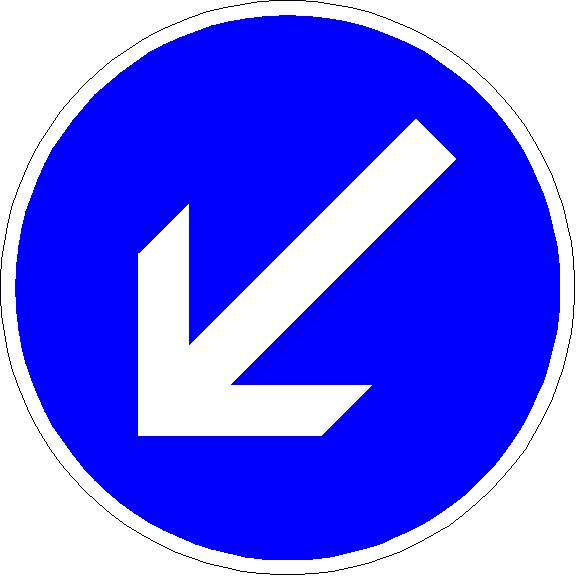

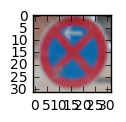

Softmaxprobability: 1.0


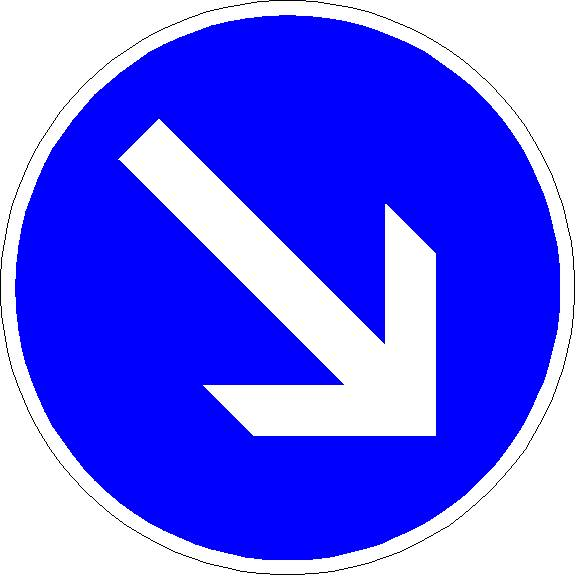

Softmaxprobability: 2.48874e-08


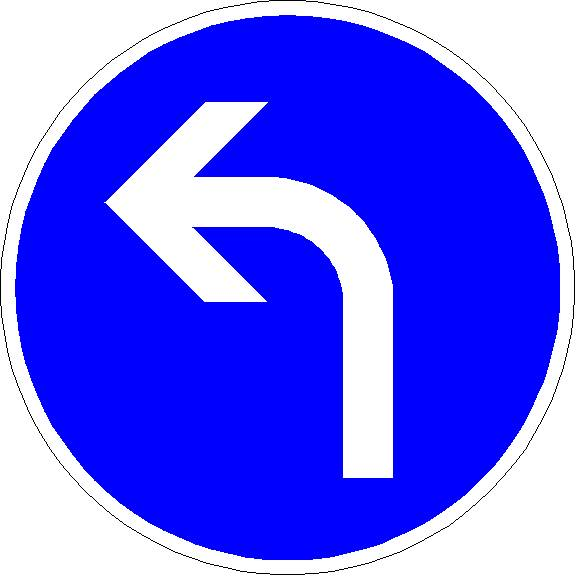

Softmaxprobability: 8.28646e-17


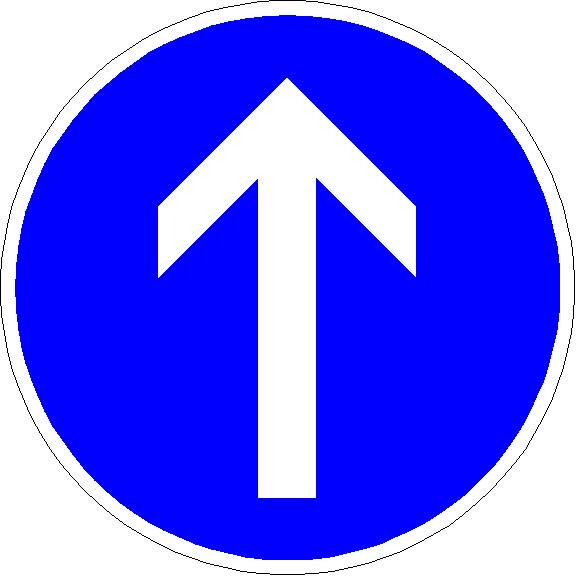

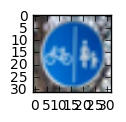

Softmaxprobability: 0.979893


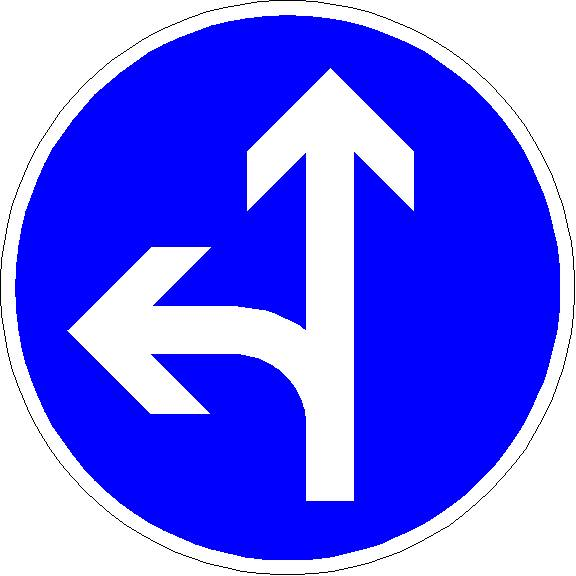

Softmaxprobability: 0.0201062


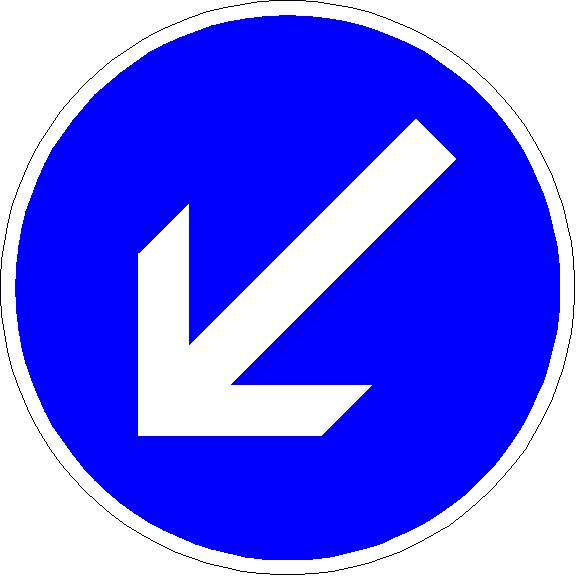

Softmaxprobability: 4.7941e-07


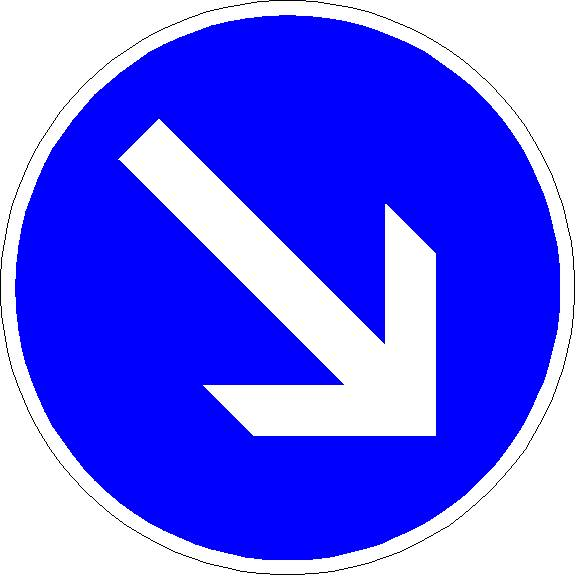

In [16]:
# Run SignNet(x) through directory 'Test' and show for every picture
# the first three classes and associated softmax probabilities.
for i in range(9):
    
    softmax = tf.nn.softmax(logits)
    with tf.Session() as sess:
        loader = tf.train.import_meta_graph('signnet.meta')
        loader.restore(sess, tf.train.latest_checkpoint('./'))
        
        sess = tf.get_default_session()
        test_image = ndimage.imread('Test/'+str(i)+'.png')
        plt.figure(figsize=(1,1))
        plt.imshow(test_image)
        plt.show()
        new_run = sess.run(tf.nn.top_k(softmax, k=3), feed_dict={x: np.asarray([test_image]), keep_prob: 1.0})
        print("Softmaxprobability: "+str(new_run.values[0][0]))
        display(Image(filename='Pictures/'+str(new_run.indices[0][0])+'.jpg', width=100))
        print("Softmaxprobability: "+str(new_run.values[0][1]))
        display(Image(filename='Pictures/'+str(new_run.indices[0][1])+'.jpg', width=100))
        print("Softmaxprobability: "+str(new_run.values[0][2]))
        display(Image(filename='Pictures/'+str(new_run.indices[0][2])+'.jpg', width=100))

In [17]:
# Use SignNet(x) on test dataset and show test accuracy
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('signnet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.910


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [18]:
# The first four test images in 'Pictures' seems to be easy to classify as
# through testing with all hyperparameters, activations functions... showed good results for them.

# The next two images seems to be rather hard to classify. Number 5 (4.jpg as we start with 0.jpg) has 
# some white scribbles (don't know the correct word for that, sorry :/) so as a output I was getting sometimes
# speed limitations (30 km/h and 70 km/h) rather than the correct result.
# This seems to be fixed with the better optimizer and all the little fixes I made for the network.
# Picture 5.jpg has slightly problems with the light and shadows - it's softmax value is not
# as near to 'one' as the first images. (This time it is at 0.9917, but mostly it is between 0.5 and 0.8 or even just place 2 or 3)

# The last 3 pictures have no correct results as their class is not in the 43 from the network.
# Just found it interesting where the network would put them in.

# Source: Took the pictures myself in the streets.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [19]:
# It seems to work quite well on booth the testing dataset (>90%) 
# and the first six pictures (100%).

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

In [20]:
### Image 5.jpg has a softmax probability between 80% and 95% most of the time, whereas
### the other pictures five pictures have a probability close to one.
### The last three pictures (without correct class) have some uncertainties (naturally)
###______________________________________________________________________________________
### I hope I answered all questions with enough details and everything else works as expected.
### Thanks in advance for the correction/revision.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.